(eda62)=

# Thresholding

In [1]:
import os
if 'jbook' in os.getcwd():
    os.chdir(os.path.abspath(os.path.join("../../..")))

import numpy as np
import cv2
import matplotlib.pyplot as plt
from myst_nb import glue

from bcd.explore.methods.threshold import (ThresholdAnalyzer,
    ThresholdLi, ThresholdISOData, ThresholdTriangle, ThresholdOTSU, ThresholdAdaptiveMean, ThresholdAdaptiveGaussian, ThresholdManual, ThresholdYen, ThresholdTriangleAnalyzer
)
from bcd.utils.visual import plot_images

img1 = "data/image/1_dev/converted/train/benign/347c2455-cb62-40f8-a173-9e4eb9a21902.png"
img2 = "data/image/1_dev/converted/train/benign/4ed91643-1e06-4b2c-8efb-bc60dd9e0313.png"
img3 = "data/image/1_dev/converted/train/malignant/7dcc12fd-88f0-4048-a6ab-5dd0bd836f08.png"
img4 = "data/image/1_dev/converted/train/malignant/596ef5db-9610-4f13-9c1a-4c411b1d957c.png"

img1 = cv2.imread(img1, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(img2, cv2.IMREAD_GRAYSCALE)
img3 = cv2.imread(img3, cv2.IMREAD_GRAYSCALE)
img4 = cv2.imread(img4, cv2.IMREAD_GRAYSCALE)

images = (img1,img2,img3,img4)

In digital mammography preprocessing, thresholding separates structures, features, and regions of interest (ROIs) from the image background based on pixel intensity values and a designated cut-off value or threshold.  From a grayscale image, a binary image is created where the pixel intensity values in the grayscale image are reduced to just two pixel intensity values in the binary image: 0 corresponding to all pixels in the grayscale image that are less than or equal to the threshold, and 1 (or 255 for 8-bit grayscale binary images) corresponding to all pixels in the grayscale image that are greater than the threshold.

## Thresholding in Digital Mammography

Segmentation based on pixel intensity thresholds is justified in digital mammography where pixel intensity is the parameter that most directly relates to the spatial characteristics of the structures within a mammogram. For this reason, threshold-based algorithm segmentation is a crucial early step in almost any digital mammography image analysis and preprocessing workflow.

## Critical Importance of Threshold

The selection of the threshold critically determines the quality of the thresholding result.

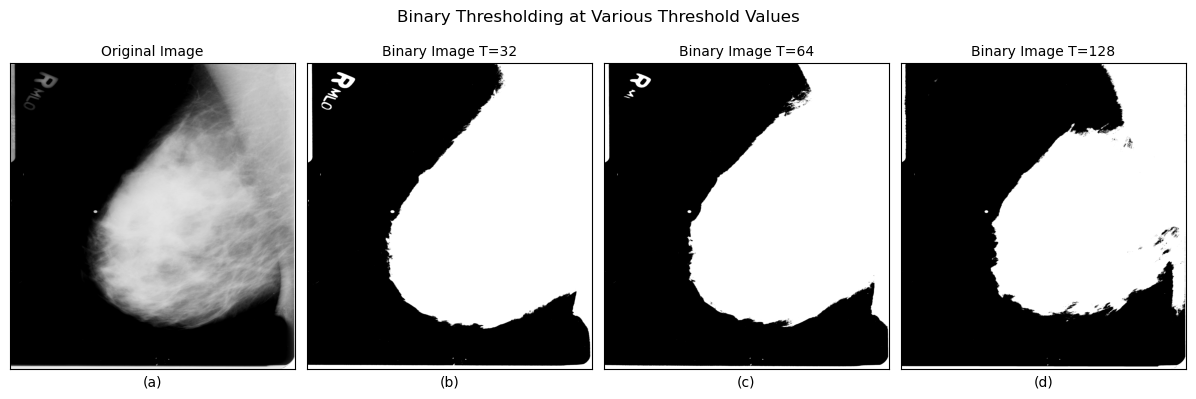

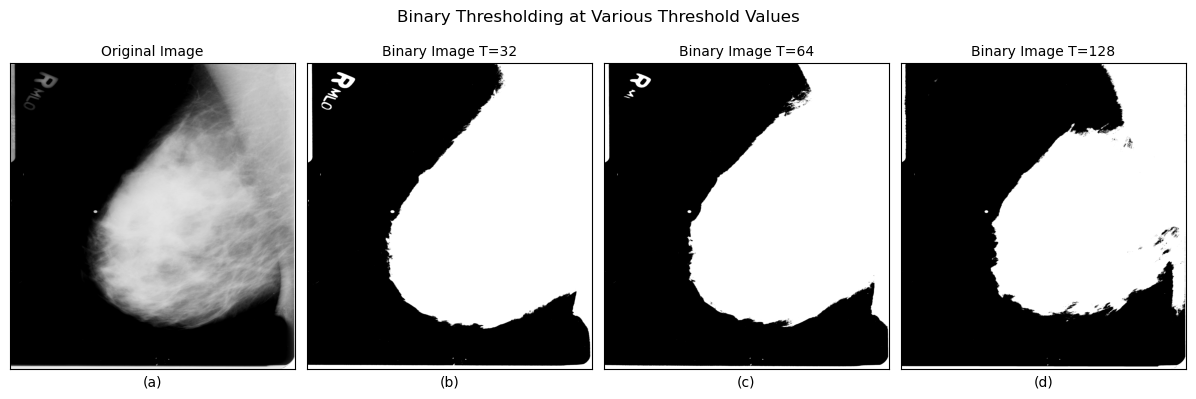

In [2]:
def plot_binary_images(image: np.ndarray, thresholds: list):
    thresholds = [32,64,128]
    images = [img3]
    for t in thresholds:
        _, img = cv2.threshold(img3, thresh=t, maxval=np.max(img3), type=cv2.THRESH_BINARY)
        images.append(img)
    titles = [f"Binary Image T={t}" for t in thresholds]
    titles = ["Original Image"] + titles
    title = "Binary Thresholding at Various Threshold Values"
    return plot_images(images=images, titles=titles, title=title)

thresholds = [32,64,128]
fig = plot_binary_images(image=img3, thresholds=thresholds)
glue("various_thresholds", fig)

```{glue:figure}
---
align: center
name: various_thresholds_fig
---
Impact of Threshold Value on Binarization
```

{numref}`various_thresholds_fig` illustrates the impact of various threshold values on the binarization result.  As the threshold value increases from $T=32$ to $T=128$, we notice a few things:

- **Border Smoothness**:  Borders tend to become increasingly rough as threshold value increases.
- **Information Loss**.  Threshold value and information loss are positively correlated. High thresholds can shrink objects to the background as indicated in {numref}`various_thresholds_fig`  (d).
- **Artifact Removal**: On the other hand, some information loss is acceptable if that information is an artifact. Higher thresholds tend to be associated with greater artifact removal.

And there's the trade-off. {numref}`various_thresholds_fig` clearly illustrates the importance of selecting an appropriate threshold, so what principled techniques exist for selecting thresholds that balance information capture and artifact removal?

Well, manual techniques can be tedious, and time-consuming, and don’t reflect the inherent variability in digital mammography. No single threshold value will perform consistently across all images.  And though no universally superior *automated* thresholding method exists, several techniques have been proposed, each with distinct performance characteristics, strengths, and weaknesses, that have broad applicability across a range of image analysis and processing domains. We’ll examine those next.

## Automated Thresholding Algorithms

Sezgin and Sankur {cite}`sankurSurveyImageThresholding2004` cast the space of automated thresholding techniques as follows: [^thresholds]
``
- **Histogram shape-based** methods that analyze, for instance, the peaks, valleys, and curvatures of smoothed histograms.
- **Clustering-based methods** cluster the gray-level samples into background and foreground. Alternatively, the image is modeled as a mixture of two Gaussians.
- **Entropy-based methods** use the entropy of the foreground and background regions, the cross-entropy between the original and binarized image, etc.
- **Object attribute-based** methods that analyze the similarity between the gray-level and the binarized images, such as fuzzy shape similarity, edge coincidence, etc.
- **The spatial methods** use higher-order probability distribution and/or correlation between pixels
- **Local methods adapt** the threshold value on each pixel to the local image characteristics.

For this effort, eight automated thresholding techniques {numref}`auto-thresh-tbl` were selected based on the intrinsic properties of the CBIS-DDSM dataset.

```{table}
:name: auto-thresh-tbl

| # | Type                    | Method                               | Author(s)                                            | Publication                                                  |
|---|-------------------------|--------------------------------------|------------------------------------------------------|--------------------------------------------------------------|
| 1 | Histogram-Based         | Triangle Method                      | Zack, G. W., Rogers, W. E. and Latt, S. A., 1977,    | Automatic Measurement of Sister Chromatid Exchange Frequency |
| 2 | Cluster-Based           | ISOData Method                       | Ridler, TW & Calvard, S (1978)                       | Picture thresholding using an iterative selection method     |
| 3 | Histogram/Cluster-Based | Otsu's Method                        | Nobuyuki Otsu (1979)                                 | A threshold selection method from gray-level histograms      |
| 4 | Entropy-Based           | Li's Minimum Cross-Entropy Method    | Li C.H. and Lee C.K. (1993)                          | Minimum Cross Entropy Thresholding                           |
| 5 | Spatial-Based           | Yen's Multilevel Thresholding Method | Jui-Cheng Yen, Fu-Juay Chang, and Shyang Chang (1995) | A new criterion for automatic multilevel thresholding        |
| 7 | Local                   | Adaptive Mean Method             | Bradley, D., G. Roth 2007                            | Adapting Thresholding Using the Integral Image               |
| 8 |                         | Adaptive Gaussian Method                 | Bradley, D., G. Roth 2007                            | Adapting Thresholding Using the Integral Image

```

### Triangle Method

The Triangle method was proposed in 1977 as a method for automatically detecting and counting sister chromatid exchanges in human chromosomes {cite}`zackAutomaticMeasurementSister1977`.

```{figure}
---
name: triangle
---
Triangle Thresholding Method
```

{numref}`triangle` was taken from the original paper and geometrically depicts the triangle threshold method. The threshold is selected by first normalizing the dynamic range and the counts of the intensity histogram to values in [0,1]. A line is then constructed between the histogram peak and the tip of the long tail. Point A is selected at the base of the histogram bin that has the maximum perpendicular distance from the ‘peak-to-tip’ line. The threshold is set to A $+\delta \ge 0$.

This method was applied to four test images of varying breast densities, contrast, abnormalities, and diagnoses. {numref}`threshold_triangle_fig` shows the original images (a)-(d), the binary images (e)-(h), the segmentation results (i)-(l), and the triangle histograms with thresholds annotated (m)-(p).

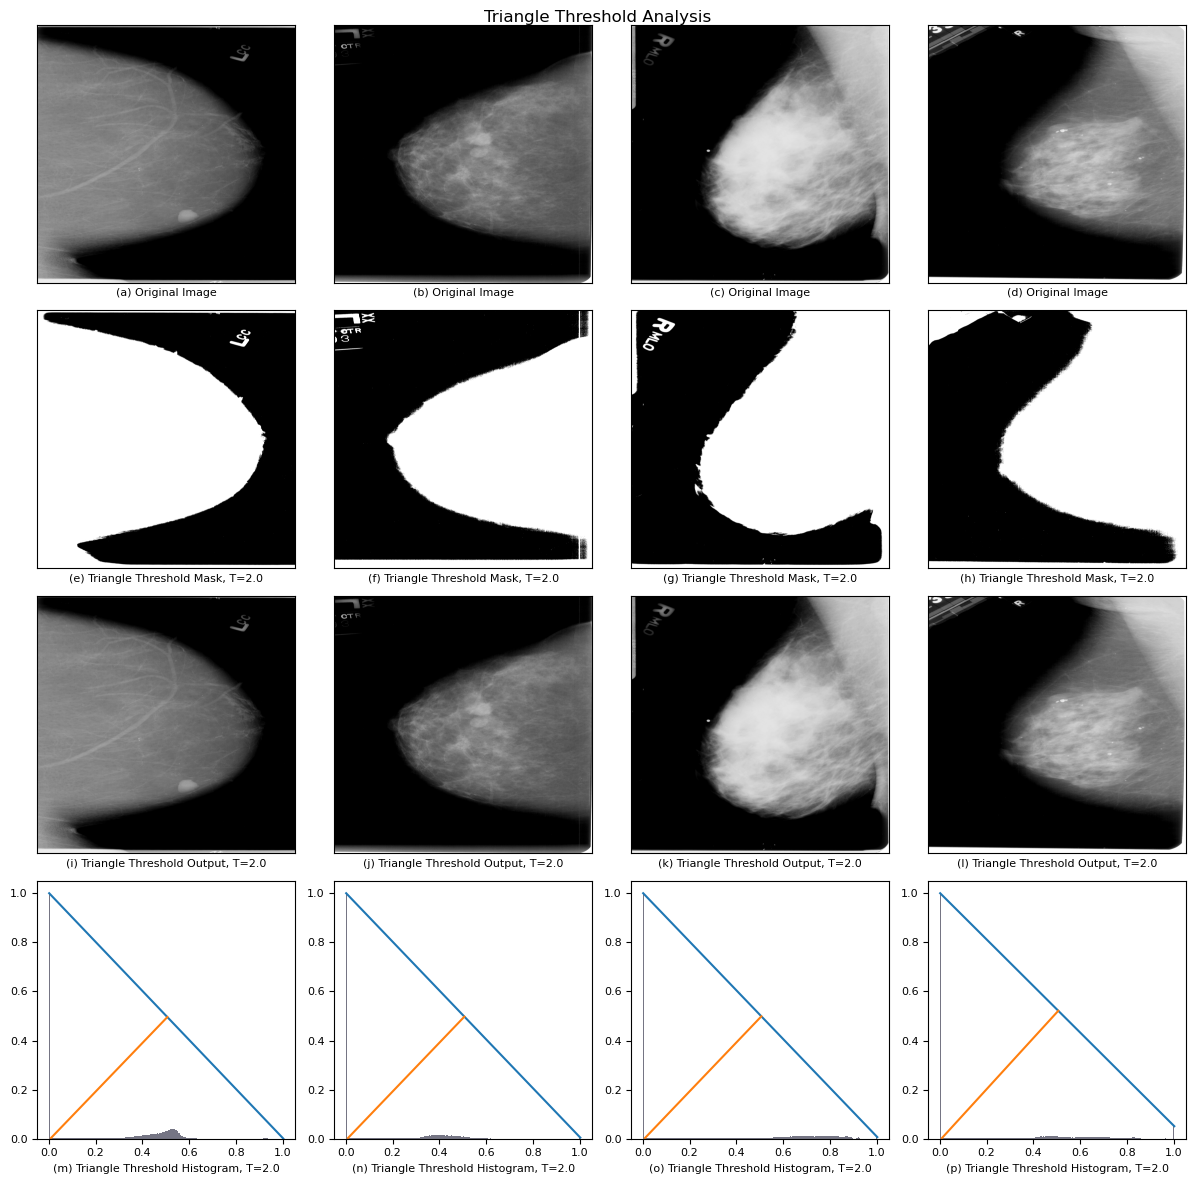

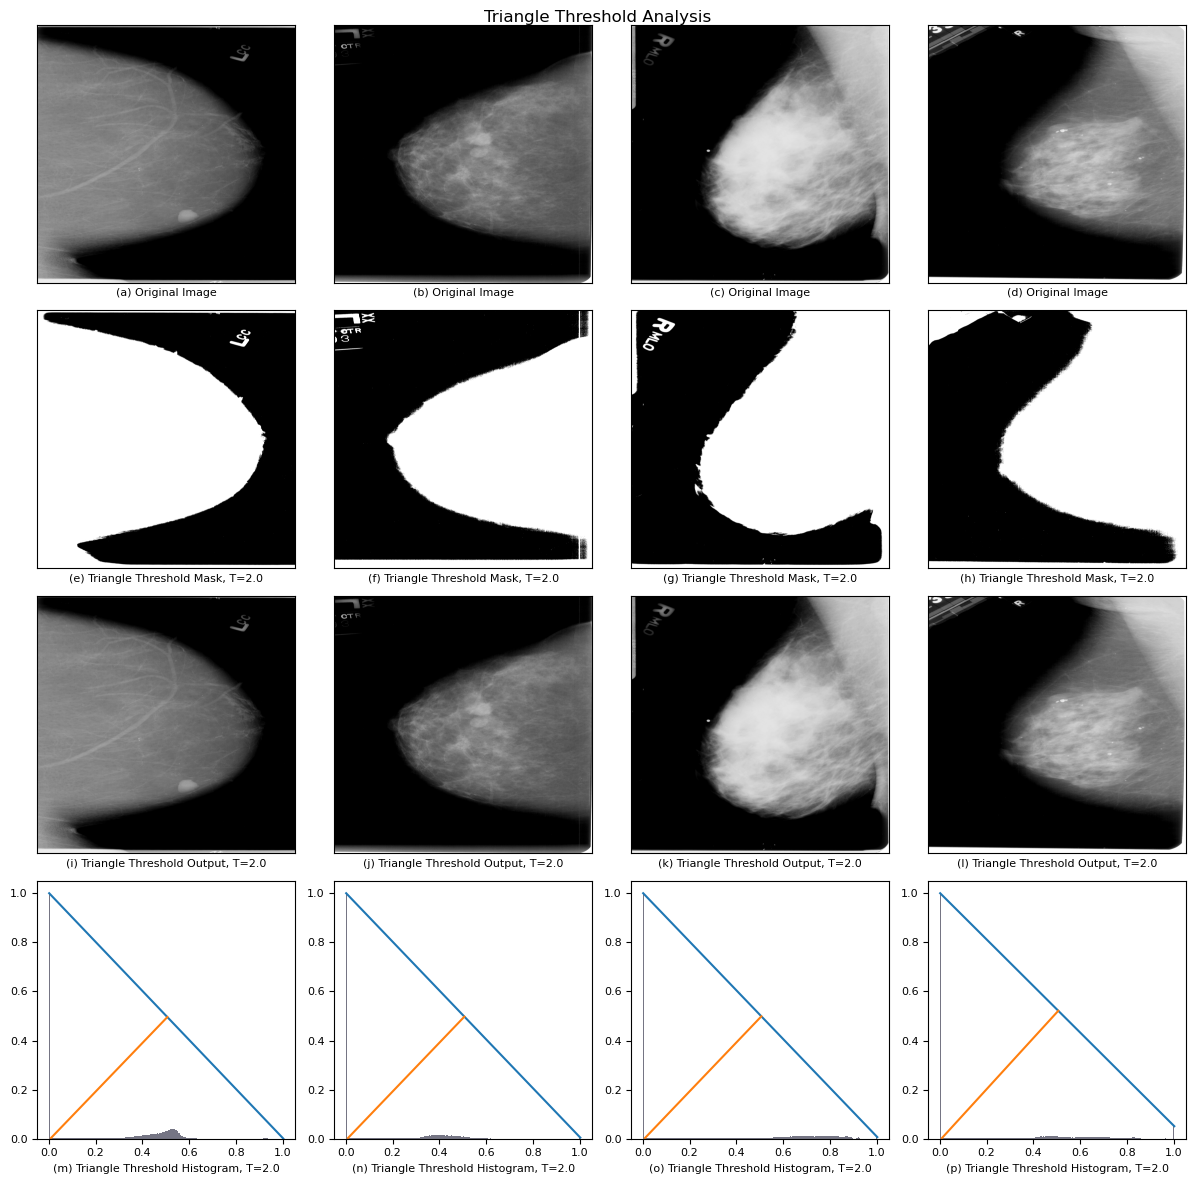

In [3]:
analyzer = ThresholdTriangleAnalyzer()
threshold = ThresholdTriangle()
fig = analyzer.analyze(images=images, threshold=threshold)

glue("threshold_triangle", fig)

```{glue:figure}
---
align: center
name: threshold_triangle_fig
---
Triangle Threshold Segmentation Method. (a) through (d) are the original images, (e) through (h) are the binary masks, (i) through (l) are the segmented images and the normalized histograms and thresholds are presented at (m) through (p)
```

Several observations can be made. First, all images had the same threshold $T=2$, despite varying levels of contrast, illumination, and breast density. Second, at $T=2$, we have little to no artifact removal as their pixel intensities are not distinguished from other foreground structures. Overall, the algorithm effectively distinguished the breast tissue from the background with no apparent loss of information.

The triangle method assumes pixel intensity distributions with a maximum peak near one end of the histogram and searches for thresholds towards the other end. Hence, this method is particularly well suited for images with highly skewed pixel intensity distributions with a single dominant peak and one or more weak peaks as we see here.

### ISODATA Method

The ISODATA method is an iterative approach based upon the Iterative Self-Organizing Data Analysis algorithm (ISODATA) algorithm {cite}`ridlerPictureThresholdingUsing1978` and is commonly used in biomedical imaging.

In general, it first assigns an initial threshold $T$, usually the average of the pixel intensities in the image. The second step classifies each pixel to the closest class. In the third step, the mean values $\mu_1$ and $\mu_2$ for each class are estimated using a Gaussian distribution. Next, a new threshold is selected as the average of $\mu_1$ and $\mu_2$ {cite}`el-zaartImagesThresholdingUsing2010`.  Steps two and three are repeated until the change in threshold is less than a predesignated parameter.

In {numref}`threshold_isodata_fig` we have the segmentation results for the ISODATA method applied to our test images.

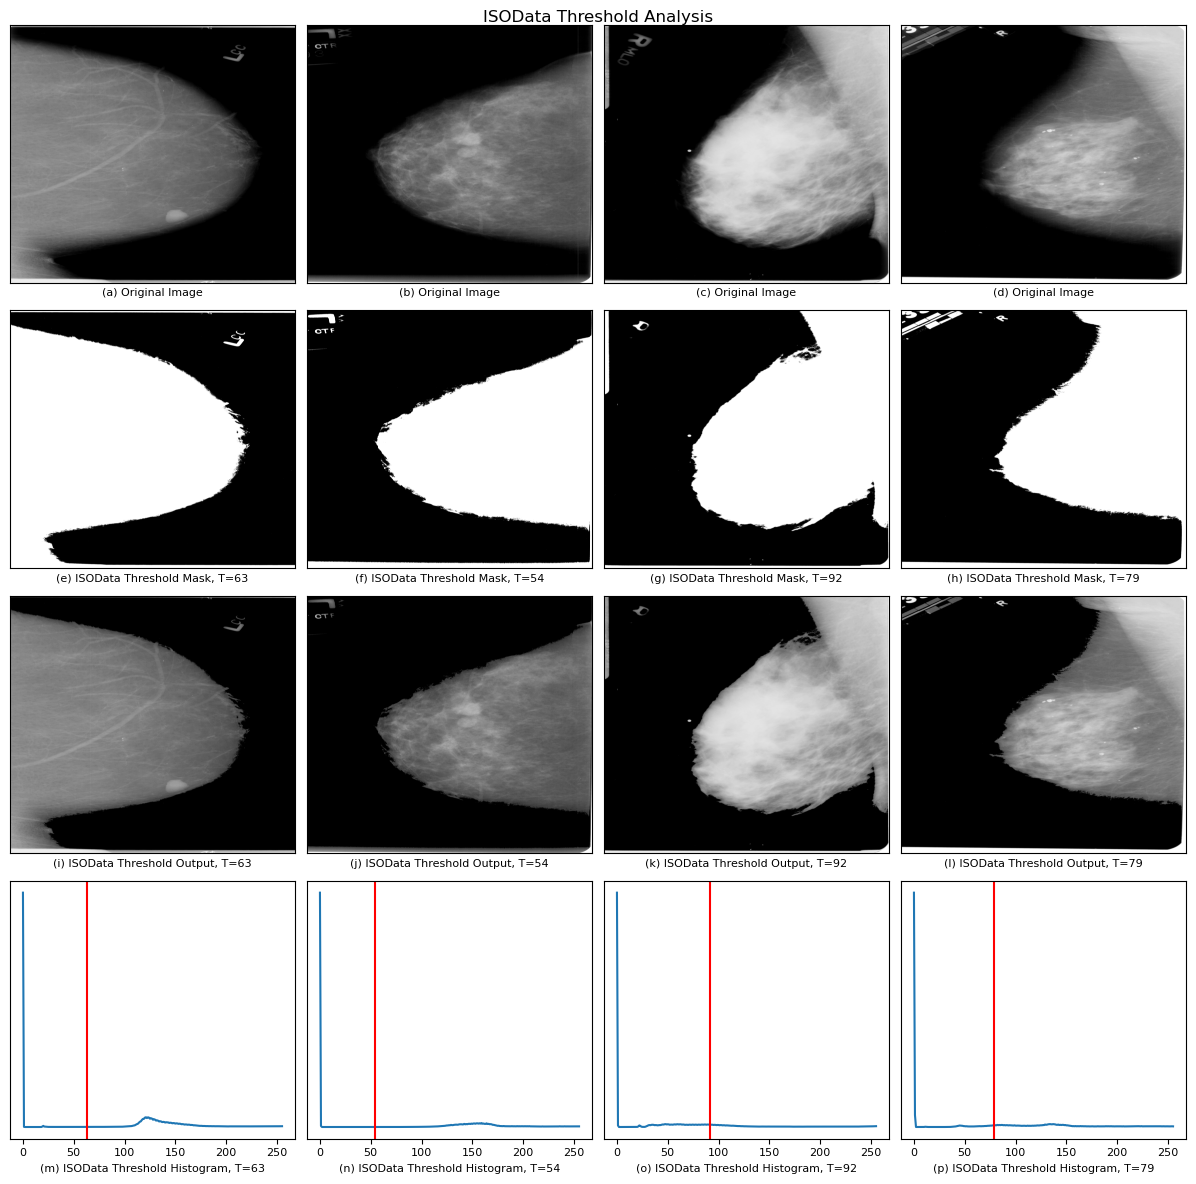

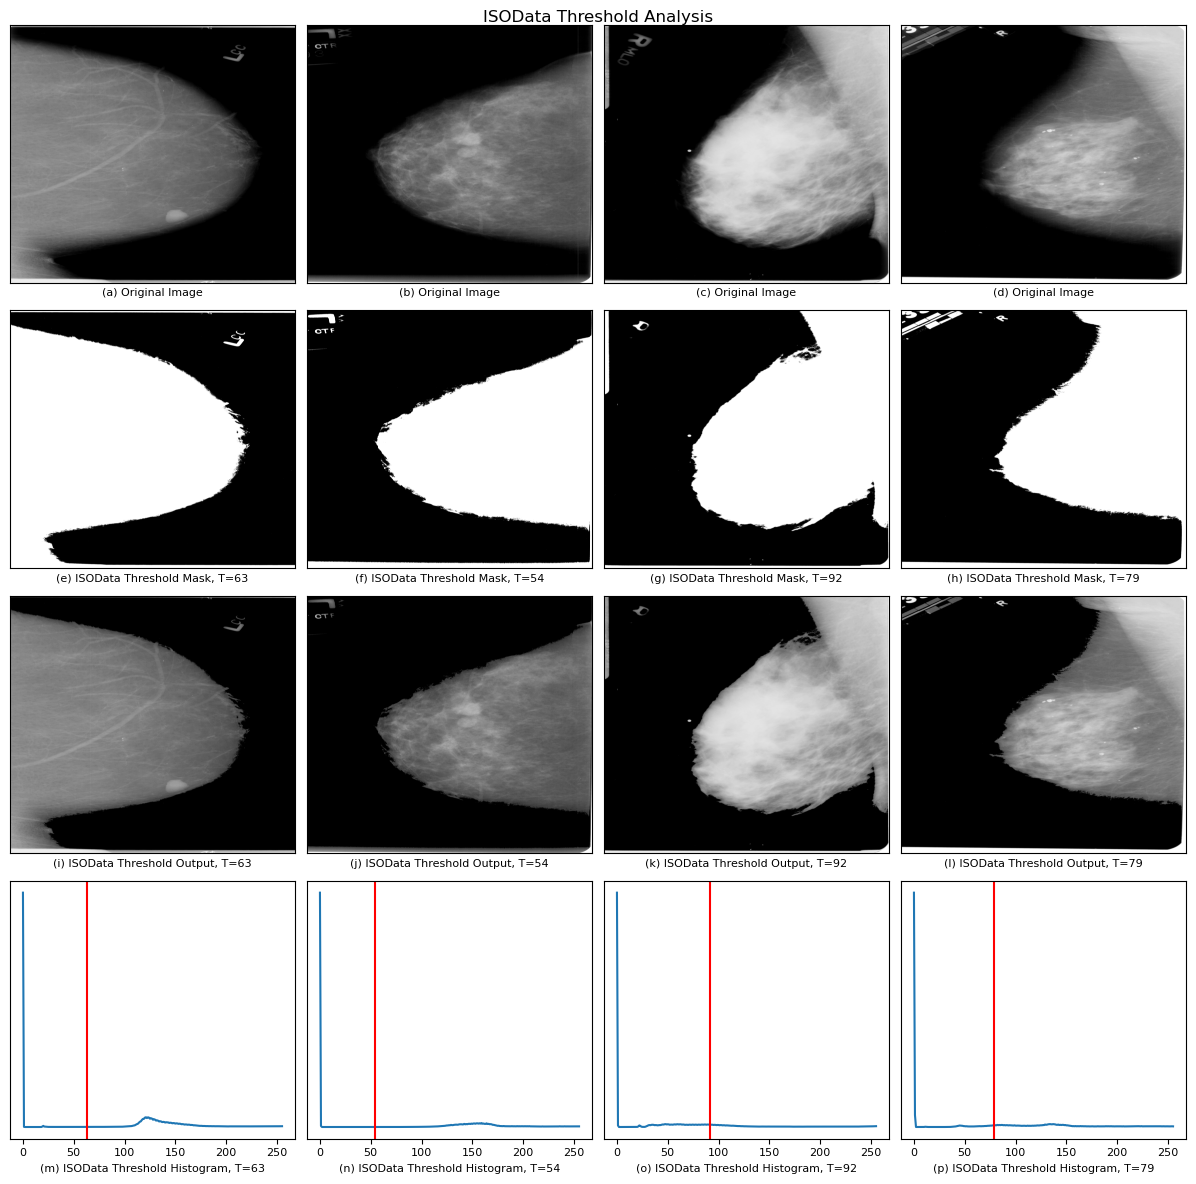

In [4]:
analyzer = ThresholdAnalyzer()
threshold = ThresholdISOData()
fig = analyzer.analyze(images=images, threshold=threshold)

glue("threshold_isodata", fig)

```{glue:figure}
---
align: center
name: threshold_isodata_fig
---
ISOData Threshold Segmentation Method. (a) through (d) are the original images, (e) through (h) are the binary masks, and (i) through (l) are the segmented images.
```

The ISODATA method generated higher thresholds in [63, 54, 92, 79] with slightly more roughness along the edges.

An advantage of the ISOData method is that one doesn't need to know much about the properties of the image in advance.  On the other hand, the ISODATA algorithm assumes a symmetric Gaussian pixel distribution and may not perform well with images with a non-symmetric histogram as we've observed here.

### Otsu's Method

Otsu's Method {cite}`otsuThresholdSelectionMethod1979`  is a very popular image thresholding technique that separates images into two classes by minimizing the intra-class variance, denoted as $\sigma^2_w(t)$. Let’s build this from the bottom up.

The Otsu method initializes the threshold $t=0$, then computes the image histogram and probabilities of each intensity level $p(i)$ denoted as:

```{math}
:label: otsu_prob
p(i) = \frac{n_i}{n}
```

where  $i$ is a pixel intensity level, $n_i$ is the number of pixels with intensity level $i$, and $n$ is the total number of pixels.

Next, the image is split into two classes: $C_0$  containing all pixels with intensity in the range [0,t), and $C_1$ which contains all pixels with intensity in the range [t, L], where L is the number of bins in the histogram.

The next step is to obtain weights for $C_0, and $C_1$, denoted $w_0(t)$ and $w_1(t)$, respectively.

```{math}
:label: otsu_weights
w_0(t) = \sum_{i=0}^{t-1} p(i), \\
w_1(t) = \sum_{i=t}^{L-1} p(i),
```

Next, the means for $C_0$ and $C_1$, denoted $\mu_0$ and $\mu_1$, respectively:

```{math}
:label: otsu_means
\mu_0(t) = \frac{\sum_{i=0}^{t-1} ip(i)}{w_0{t}}, \\
\mu_1(t) = \frac{\sum_{i=t}^{L-1} ip(i)}{w_1{t}},
```

Now, we compute the weighted variance of each class, denoted as $\sigma_0^2$, and $\sigma_1^2$:

```{math}
:label: otsu_cvar
\sigma_0^2(t) = \sum_{i=0}^{t-1}[i-\mu_0(t)]^2 \frac{p(i)}{w_0(t)} \\
\sigma_1^2(t) =  \sum_{i=t}^{L-1}[i-\mu_1(t)]^2 \frac{p(i)}{w_1(t)}
```

From {cite}`otsuThresholdSelectionMethod1979`  we have two options to find the threshold. The first is to minimize intra-class variance as follows:

```{math}
:label: otsu_ivar
\sigma_w^2(t) =w_0(t)\sigma^2_0(t)+w_1(t)\sigma^2_1(t).
```

The second method is to maximize inter-class variance as follows:

```{math}
:label: otsu_bvar
\sigma_b^2(t) =w_0(t)w_1(t)[\mu_0(t)-\mu_1(t)]^2
```

The method we will be using minimizes the **intra-class variance**.

Hence, the general algorithm for minimizing the intra-class variance is given by:

1. Initialize threshold $t=0$
2. Calculate the histogram and intensity level probabilities $p(i)$
3. Initialize $w_0(0)$ and $w_1(0)$
4. FOR t in range (0,L-1)
   - Update values of $w_i,\mu_i,$ where $w_i$ is the weighted probability and $\mu_i$ is the mean of class $i$.
   - Calculate the intra-class variance value $\sigma_w^2(t)$
5. The final threshold is that which minimizes $\sigma_w^2(t)$

Let's examine Otsu's method on our test images.

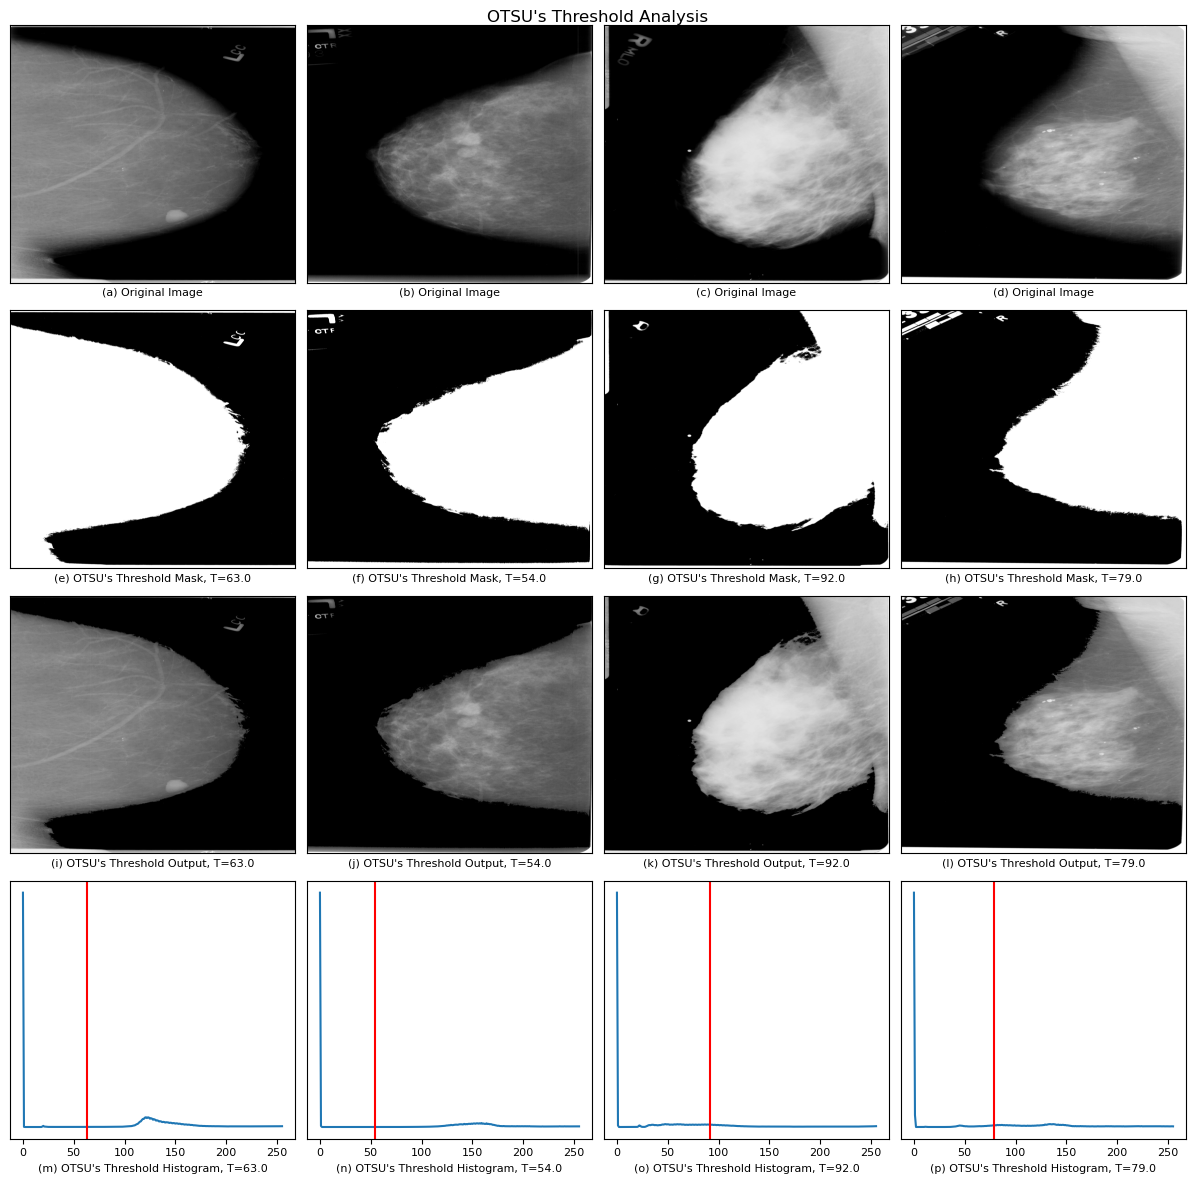

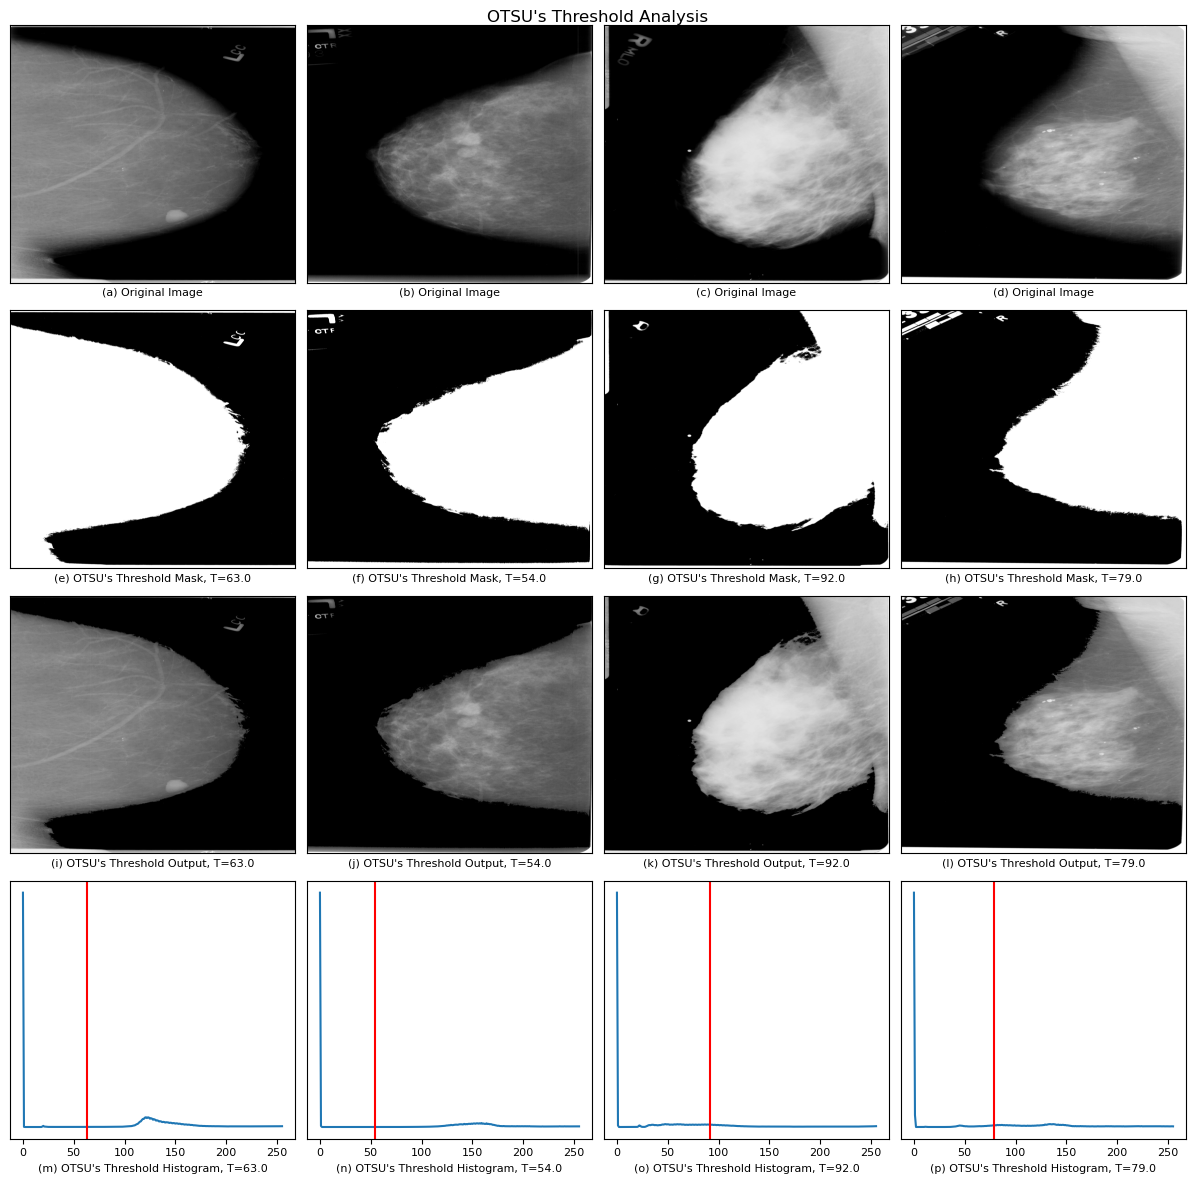

In [5]:
analyzer = ThresholdAnalyzer()
threshold = ThresholdOTSU()
fig = analyzer.analyze(images=images, threshold=threshold)

glue("threshold_otsu", fig)

```{glue:figure}
---
align: center
name: threshold_otsu_fig
---
OTSU's Threshold Segmentation Method. (a) through (d) are the original images, (e) through (h) are the binary masks, and (i) through (l) are the segmented images.
```

What stands out immediately, is that the selected thresholds for the Otsu method and the ISODATA method on our test set are precisely the same.

The Otsu method performs well when the image histogram is bimodal with a deep and sharp valley between two peaks {cite}`kittlerThresholdSelectionUsing1985`.  However, the method isn’t the best choice in the presence of heavy noise,  large variances in lighting, or when intra-class variance is larger than inter-class variance.  In such cases, adaptations have been proposed such as the  Kittler-Illingworth method {cite}`kittlerMinimumErrorThresholding1986`.

### Li's Minimum Cross-Entropy Method

Probably the most popular entropy-based threshold method was proposed in 1993 by Li and Lee {cite}`liMinimumCrossEntropy1993`. It finds the 'optimal' threshold to distinguish between background and foreground by exhaustively searching for the threshold that minimized the *cross-entropy* between the foreground and the foreground mean and between the background and the background mean.

In 1998, Li and Tam implemented a faster adaptation that used the *slope* of the cross-entropy instead {cite}`liIterativeAlgorithmMinimum1998`. This version, implemented in the scikit-image package, was employed on our test images.

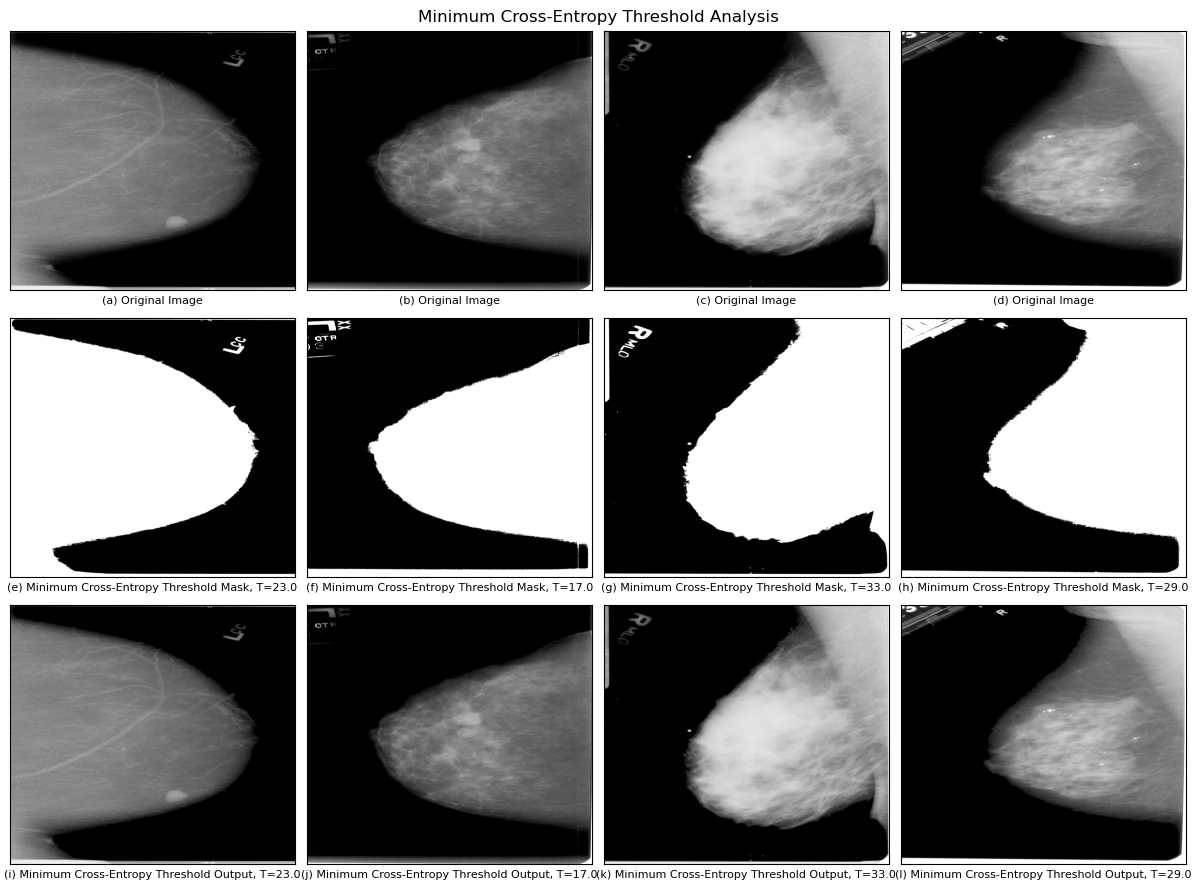

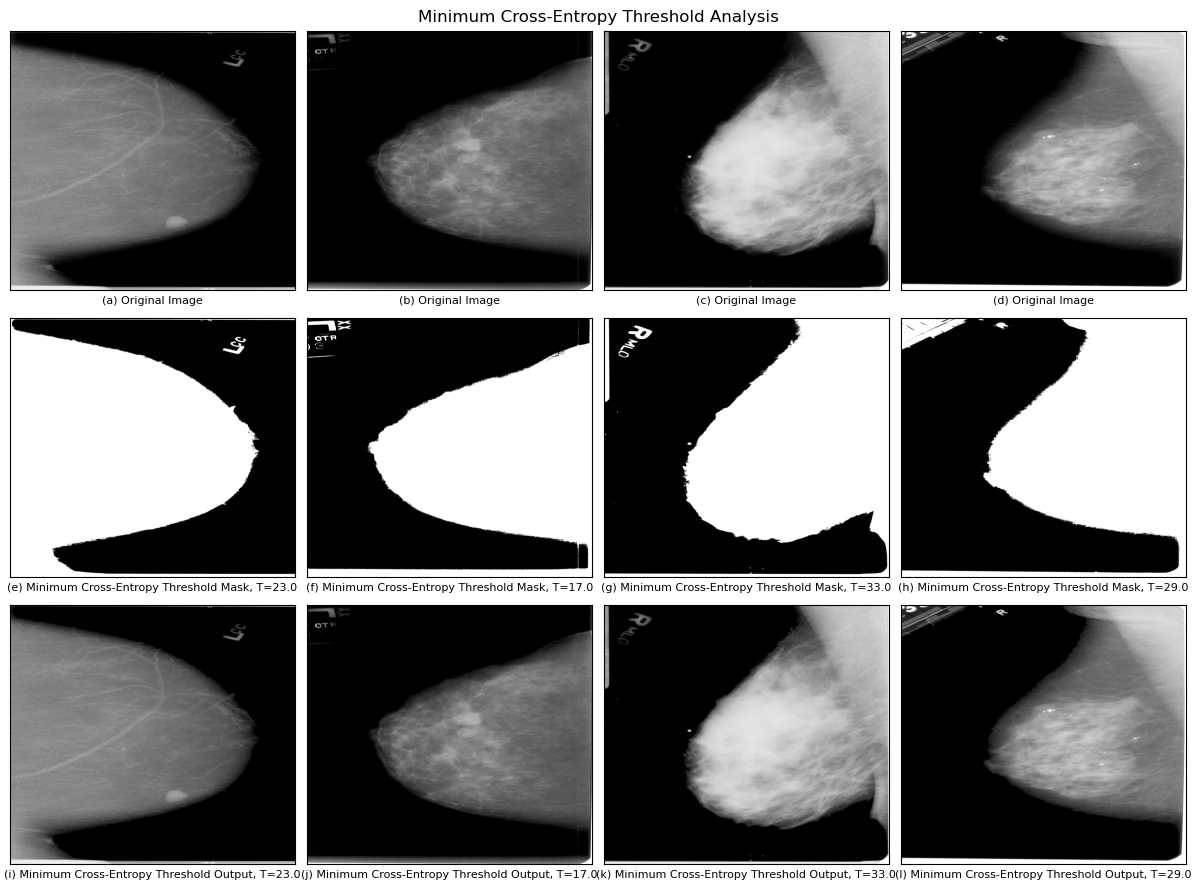

In [6]:
analyzer = ThresholdAnalyzer(show_histograms=False)
threshold = ThresholdLi()
fig = analyzer.analyze(images=images, threshold=threshold)

glue("threshold_li", fig)

```{glue:figure}
---
align: center
name: threshold_li_fig
---
Li's Minimum Cross-Entropy Threshold Segmentation Method. (a) through (d) are the original images, (e) through (h) are the binary masks, and (i) through (l) are the segmented images.
```

Li's method selected slightly lower thresholds in [23, 17, 33, 29] than those of Otsu and ISODATA. At these lower thresholds, we see slightly more smoothness on the edges.

This method works well when the image histograms are convex; however, when the pixel distributions are not convex, gradient descent could yield a threshold that is not optimal.

### Yen's Multilevel Method

Yen's Automatic Multilevel Threshold algorithm was proposed in 1995 {cite}`jui-chengyenNewCriterionAutomatic1995` based on two criteria. The first one is the discrepancy between the thresholded and original images, and the second is the number of bits required to represent the thresholded image.  The discrepancy is defined in terms of a maximum entropic correlation criterion EC for bilevel thresholding given by:

```{math}
:label: yen_ec
EC(s) = -\text{ln}(G(s)\cdot G^{\prime}(s)) + 2\text{ln}(P(s)\cdot(1-P(s)))
```

where:

```{math}
:label: yen_g
G(S)=\displaystyle\sum{i=0}^{s-1}p_i^2,\\
G^{\prime}(s)= \displaystyle\sum{i=s}^{m-1}p_i^2,
```

and $m$ is the number of gray levels in the image, $p_i$ is the probability of the gray level $i$ and $P(s)=\displaystyle\sum_{i=0}^{s-1} p_i$ is the total probability up to gray level $(s-1)$.

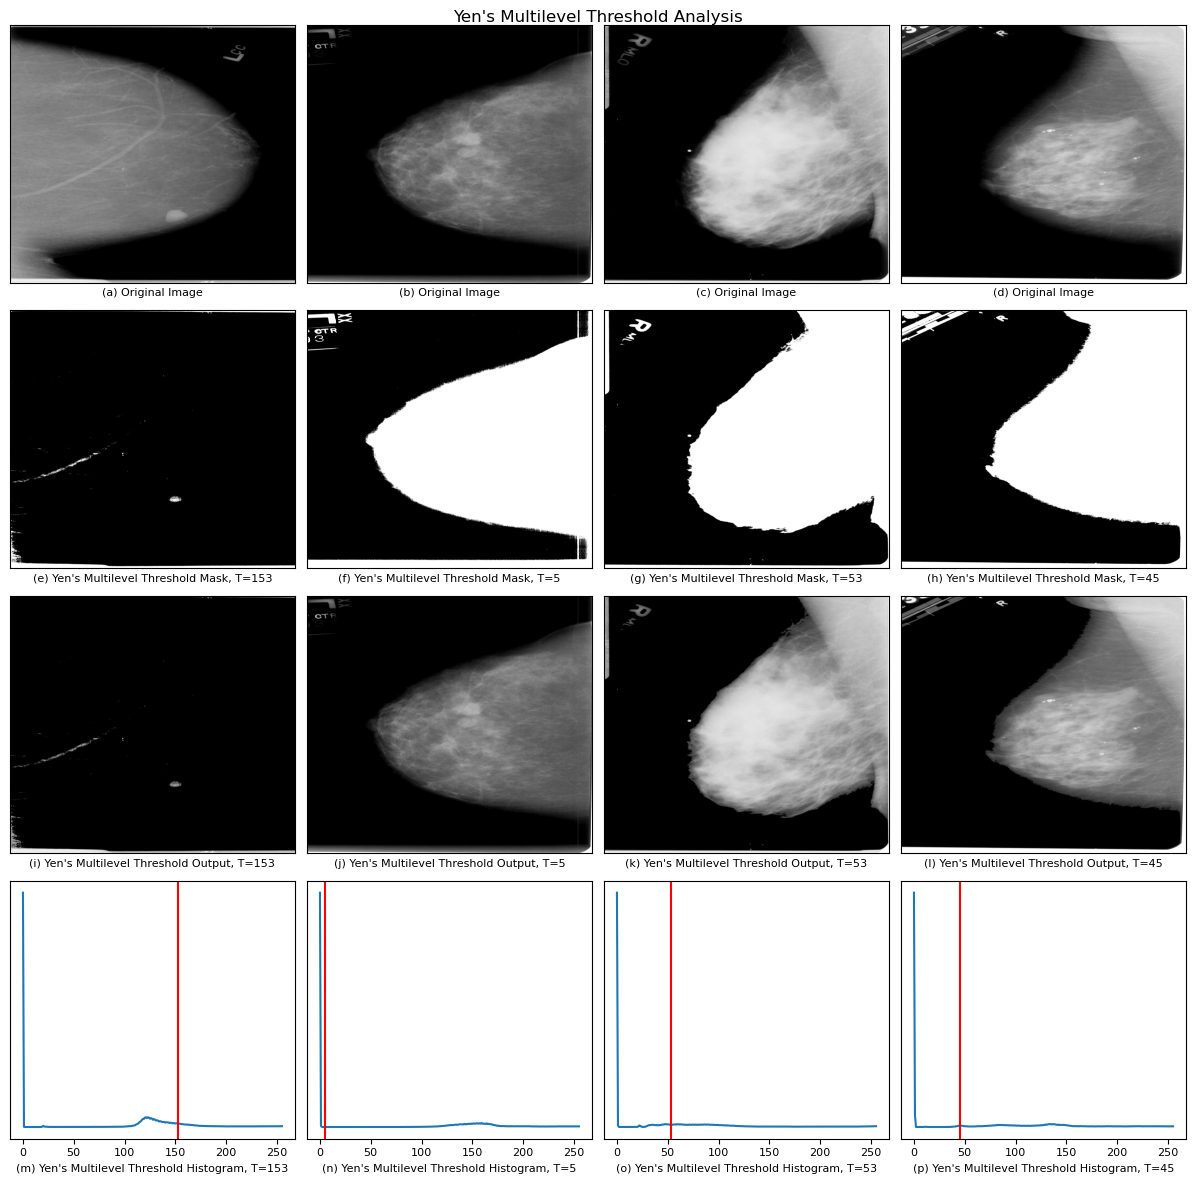

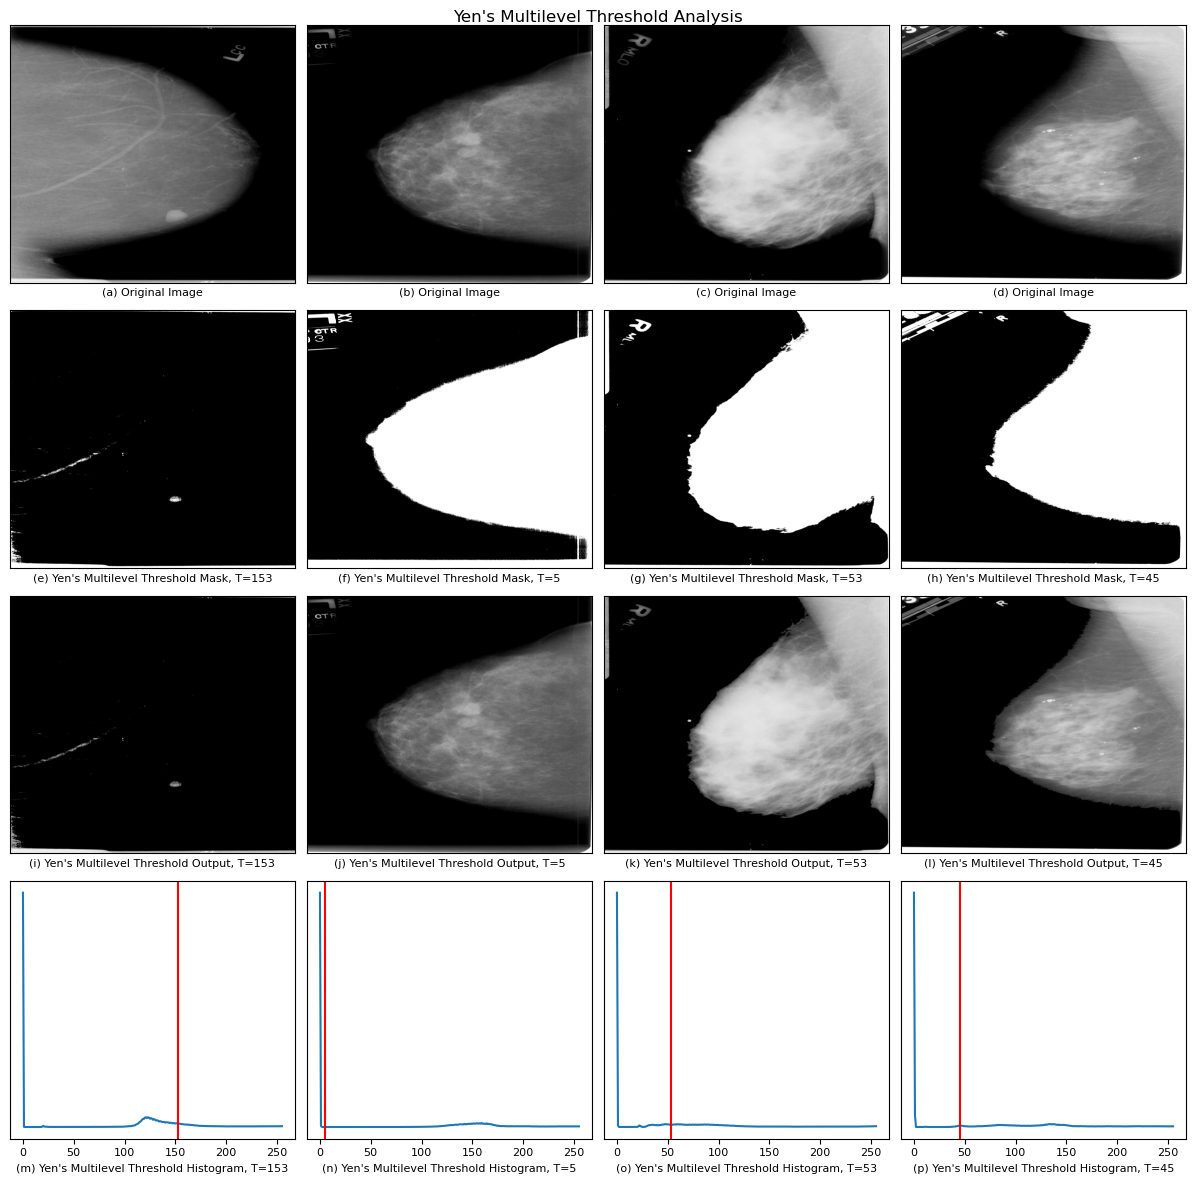

In [7]:
analyzer = ThresholdAnalyzer()
threshold = ThresholdYen()
fig = analyzer.analyze(images=images, threshold=threshold)

glue("threshold_yen", fig)

```{glue:figure}
---
align: center
name: threshold_yen_fig
---
Yen's Multilevel Threshold Segmentation Method. (a) through (d) are the original images, (e) through (h) are the binary masks, and (i) through (l) are the segmented images.
```

In {numref}`threshold_yen_fig`, Yen's algorithm performed fairly well on three of the images; however, the threshold of 153 in (e) pushed almost the entire region of interest into the background.

Yen's multilevel thresholding has several advantages and disadvantages. It allows for better image segmentation for complex images. However, it can be computationally expensive as obtaining the optimal threshold through exhaustive search increases exponentially, especially when a large number of thresholds are needed.

### Adaptive Methods

The threshold algorithms above are known as global threshold techniques. They compute a single threshold for the entire image, which may not be optimal for situations when the lighting is non-uniform across the image.

Adaptive methods, by contrast, compute thresholds for each pixel based on the intensity values in its neighborhood.  The underlying assumption of all adaptive or *local* methods is that smaller regions of an image are more likely to have approximately homogeneous illumination as opposed to the image as a whole.

Setting an appropriate neighborhood size is crucial. One that is too large would produce segmentation results similar to that of a global threshold algorithm. Neighborhood sizes are odd numbers such as 3, 5, 7, or 11.

The general formula for the adaptive method is:

```{math}
:label: adaptive
T = \text{mean}(I_L)-C
```

where the mean is either the arithmetic mean or the Gaussian mean and $I_L$ is the local neighborhood of the image $I$. The constant $C$ can be used to fine-tune the threshold value $t$.

Let's examine the performance of the adaptive mean and Gaussian methods with a neighborhood size of 5.

#### Adaptive Mean Method

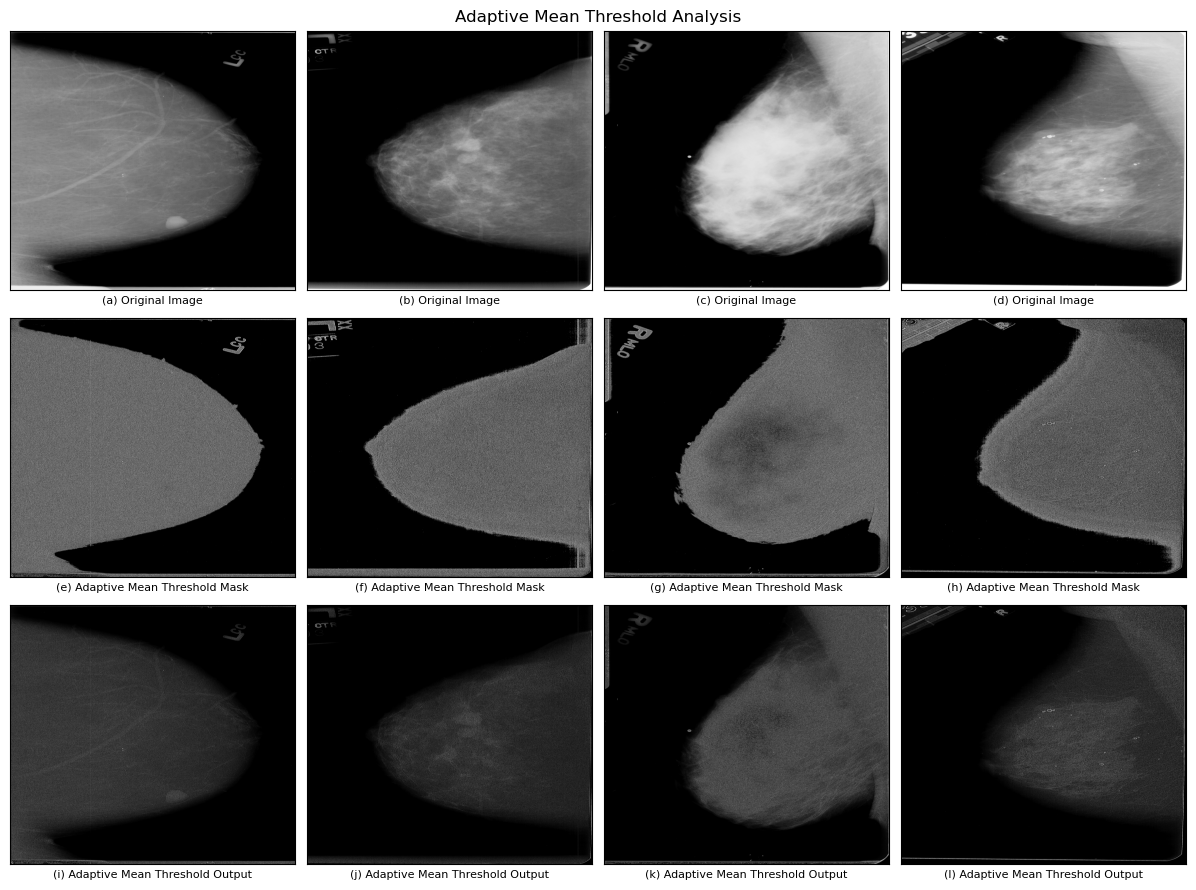

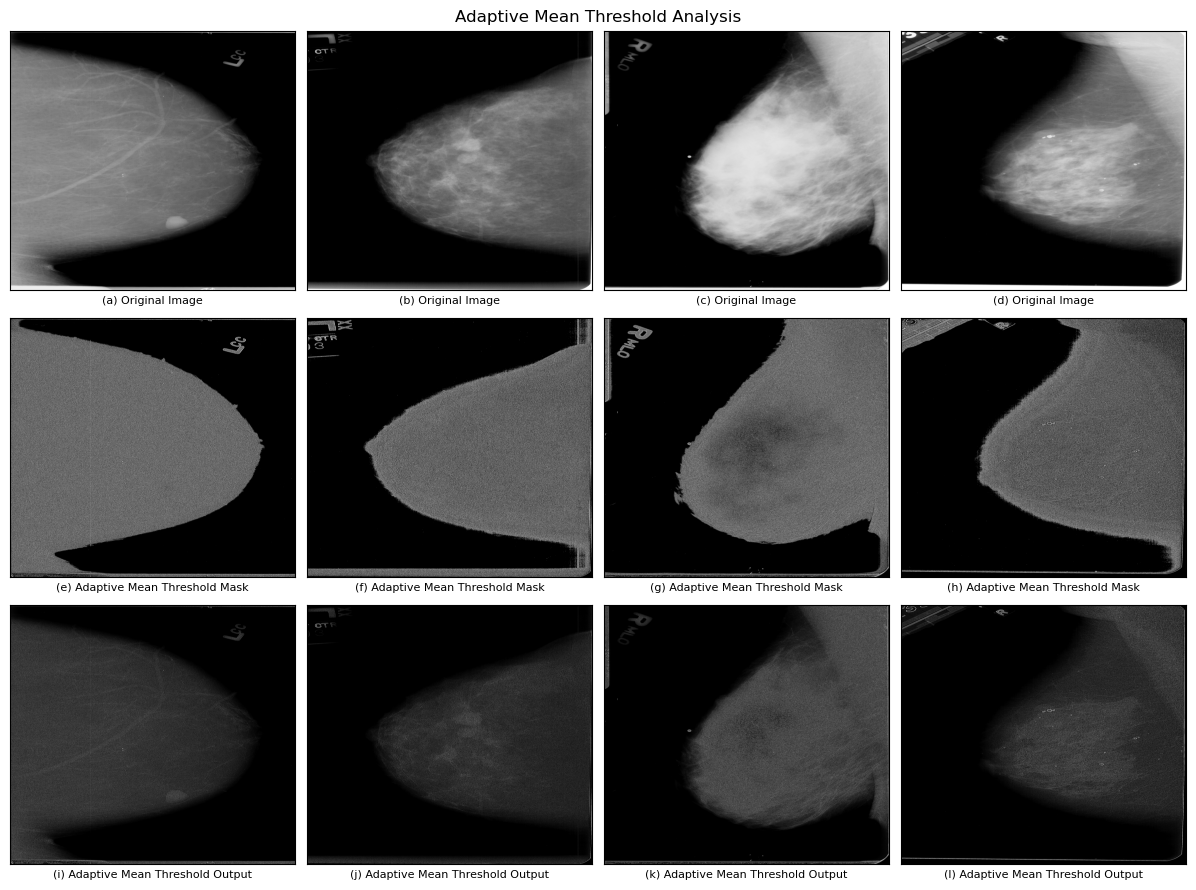

In [8]:
analyzer = ThresholdAnalyzer()
threshold = ThresholdAdaptiveMean()
fig = analyzer.analyze(images=images, threshold=threshold)

glue("threshold_local_mean", fig)

```{glue:figure}
---
align: center
name: threshold_local_mean_fig
---
Adaptive Mean Threshold Segmentation Method. (a) through (d) are the original images, (e) through (h) are the binary masks, and (i) through (l) are the segmented images.
```

#### Adaptive Gaussian Method

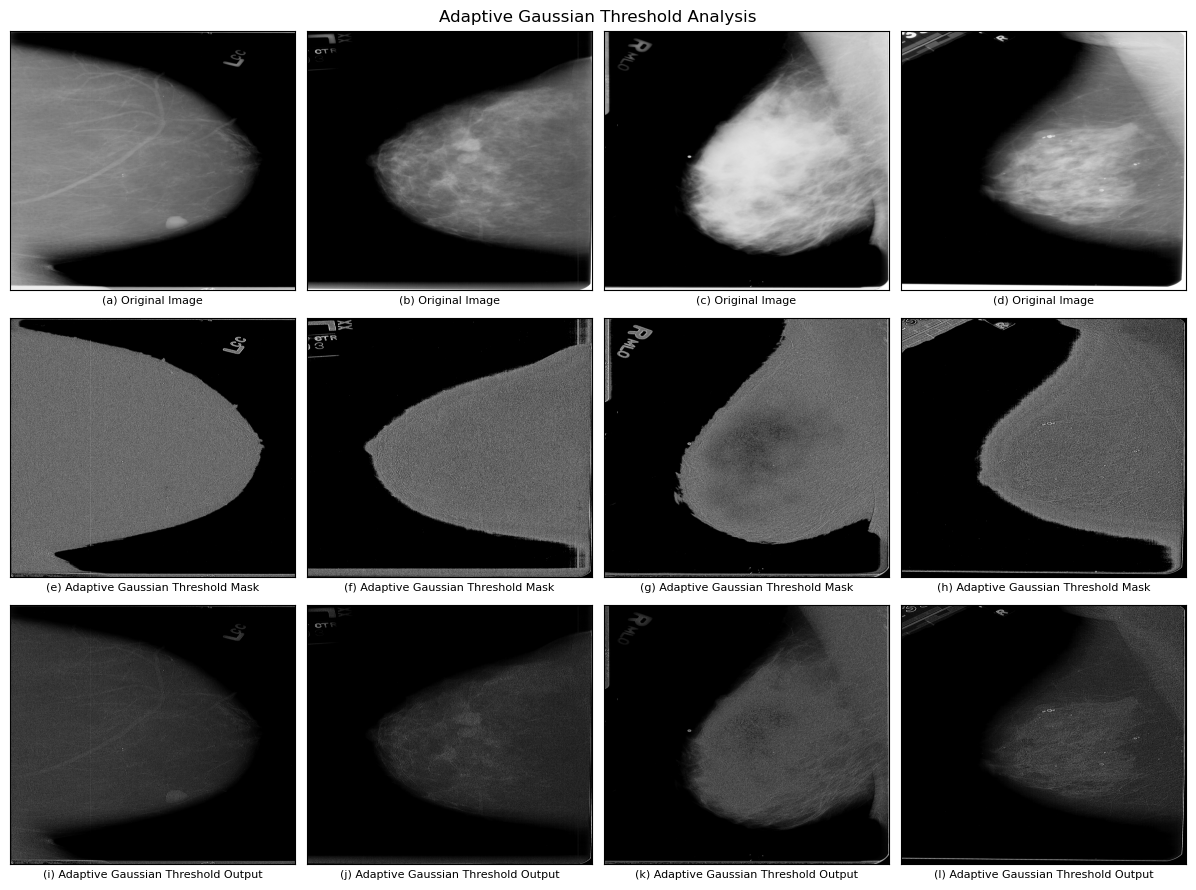

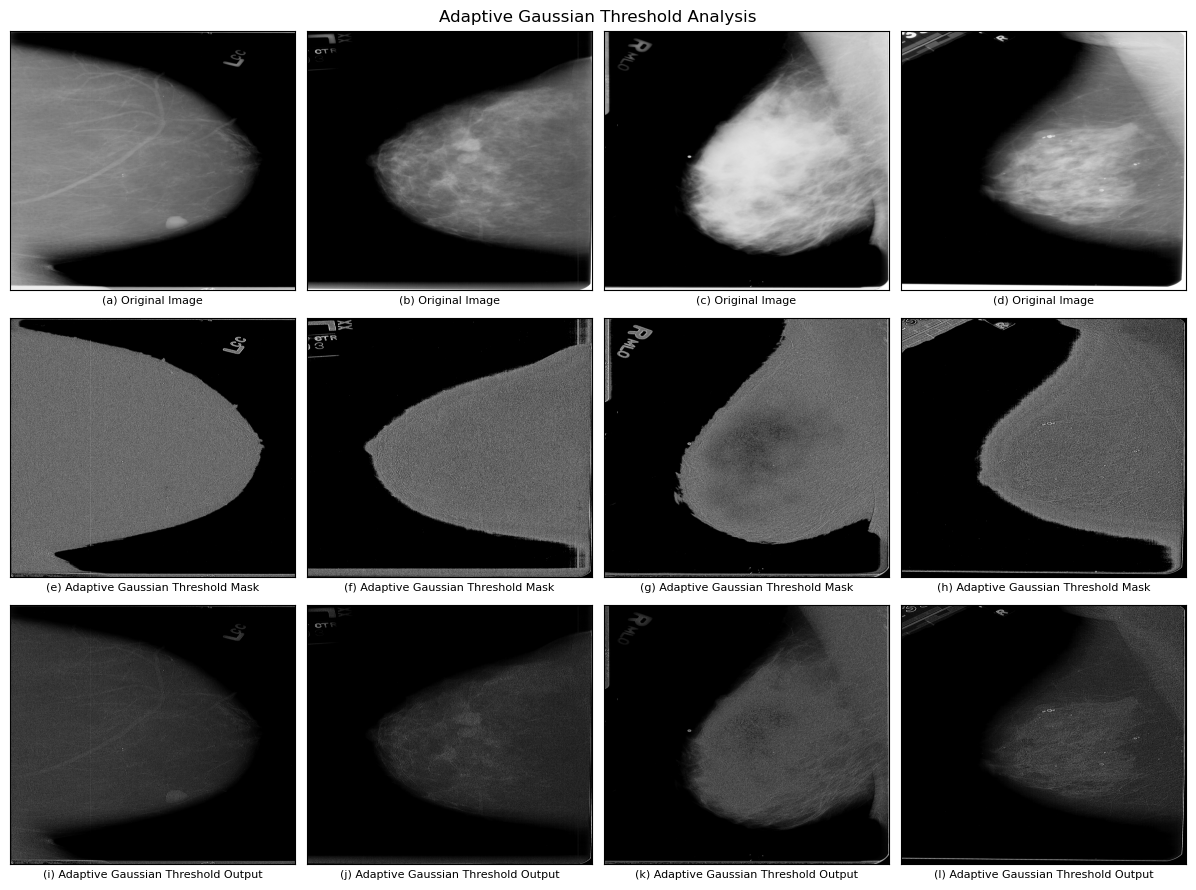

In [9]:
analyzer = ThresholdAnalyzer()
threshold = ThresholdAdaptiveGaussian()
fig = analyzer.analyze(images=images, threshold=threshold)

glue("threshold_local_gaussian", fig)

```{glue:figure}
---
align: center
name: threshold_local_gaussian_fig
---
Adaptive Gaussian Threshold Segmentation Method. (a) through (d) are the original images, (e) through (h) are the binary masks, and (i) through (l) are the segmented images.
```

{numref}`threshold_local_mean_fig` and {numref}`threshold_local_gaussian_fig` indicate that the adaptive methods are not particularly well suited for images with relatively uniform pixel distributions.

[^thresholds]: For the taxonomist, Sezgin’s framework is not mutually exclusive and collectively exhaustive (MECE). For instance, Otsu’s Method {cite}`otsuThresholdSelectionMethod1979` can be categorized as both a histogram shape-based method and a clustering-based method.